In [1]:
import VariationalBayes as vb
import LogisticGLMM_lib as logit_glmm
import VariationalBayes.SparseObjectives as obj_lib

import autograd
import unittest
import numpy.testing as np_test
import numpy as np


def simulate_data(N, K, NG):
    np.random.seed(42)
    true_beta = np.array(range(K))
    true_beta = true_beta - np.mean(true_beta)
    true_mu = 0.
    true_tau = 40.0

    x_mat, y_g_vec, y_vec, true_rho, true_u = \
        logit_glmm.simulate_data(N, NG, true_beta, true_mu, true_tau)

    return x_mat, y_g_vec, y_vec


N = 17
K = 2
NG = 7

x_mat, y_g_vec, y_vec = simulate_data(N, K, NG)
prior_par = logit_glmm.get_default_prior_params(K)
glmm_par = logit_glmm.get_glmm_parameters(K=K, NG=NG)

model = logit_glmm.LogisticGLMM(
    glmm_par, prior_par, x_mat, y_vec, y_g_vec, num_gh_points=4)
moment_wrapper = logit_glmm.MomentWrapper(glmm_par)

free_par = np.random.random(model.glmm_par.free_size())

model.glmm_par.set_free(free_par)
group_model = logit_glmm.SubGroupsModel(model)
global_model = logit_glmm.GlobalModel(model)

################################
# Test get_data_for_groups

g = 2
group_rows, y_g_select = group_model.get_data_for_groups([g])
np_test.assert_array_almost_equal(
    x_mat[group_rows, :], x_mat[y_g_vec == g, :])
np_test.assert_array_almost_equal(
    y_vec[group_rows], y_vec[y_g_vec == g])
#self.assertEqual(len(y_g_select), sum(group_rows))

########################
# Test the objectives.

# Testing the sparse objective.
g = 2
global_model.set_global_parameters()
group_model.set_group_parameters([g])
single_group_model = logit_glmm.LogisticGLMM(
    group_model.group_par, prior_par,
    x_mat[group_rows, :], y_vec[group_rows], y_g_select,
    num_gh_points = model.num_gh_points)
np_test.assert_array_almost_equal(
    single_group_model.glmm_par.get_vector(),
    group_model.group_par.get_vector(),
    err_msg='Group model parameter equality')

# Checking that a single group is equal.
single_group_kl = single_group_model.get_kl()
sparse_kl = \
    global_model.get_global_kl() + \
    group_model.get_group_kl()

# np_test.assert_array_almost_equal(
#     single_group_kl, sparse_kl,
#     err_msg="Group model kl equality")

# Checking the full kl is equal.
sparse_kl = global_model.get_global_kl()
for g in range(NG):
    group_model.set_group_parameters([g])
    sparse_kl += group_model.get_group_kl()

# np_test.assert_array_almost_equal(
#     model.objective.fun_free(free_par), sparse_kl)

# Check that the vector Hessian is equal.
model.glmm_par.set_free(free_par)
global_model.glmm_par.set_free(free_par)
group_model.glmm_par.set_free(free_par)

sparse_vector_hess = \
    group_model.get_sparse_kl_vec_hessian(print_every_n=-1) + \
    global_model.get_sparse_kl_vec_hessian()
full_vector_hess = \
    model.objective.fun_vector_hessian(model.glmm_par.get_vector())

# np_test.assert_array_almost_equal(
#     full_vector_hess,
#     np.array(sparse_vector_hess.todense()),
#     err_msg='Sparse vector Hessian equality')







# # Check that the free Hessian is equal.
# #sparse_hess = sparse_model.get_free_hessian(sparse_vector_hess)
# sparse_hess = logit_glmm.get_free_hessian(
#     model, group_model=group_model, global_model=global_model)
# full_hess = model.objective.fun_free_hessian(
#     model.glmm_par.get_free())

# np_test.assert_array_almost_equal(
#     full_hess,
#     np.asarray(sparse_hess.todense()),
#     err_msg='Sparse free Hessian equality')

# # Check that the weight jacobian is equal.
# sparse_jac = group_model.get_sparse_weight_vec_jacobian()
# def get_data_terms_vec(glmm_par_vec):
#     model.glmm_par.set_vector(glmm_par_vec)
#     return model.get_data_log_lik_terms()
# def get_data_terms_free(glmm_par_free):
#     model.glmm_par.set_free(glmm_par_free)
#     return model.get_data_log_lik_terms()

# model.use_weights = True
# def get_weighted_kl_vec(weights, vec_par):
#     model.glmm_par.set_vector(vec_par)
#     model.weights = weights
#     return model.get_kl()

# def get_weighted_kl_free(weights, free_par):
#     model.glmm_par.set_free(free_par)
#     model.weights = weights
#     return model.get_kl()

# get_weighted_kl_vec_grad = autograd.grad(get_weighted_kl_vec, argnum=0)
# get_weighted_kl_vec_jac = autograd.jacobian(
#     get_weighted_kl_vec_grad, argnum=1)
# full_jac = get_weighted_kl_vec_jac(
#     model.weights, model.glmm_par.get_vector())

# #self.assertEqual(full_jac.shape, sparse_jac.shape)
# np_test.assert_array_almost_equal(
#     full_jac,
#     np.asarray(sparse_jac.todense()),
#     err_msg='Sparse vector Jacobian equality')

# sparse_free_jac = \
#     logit_glmm.get_sparse_weight_free_jacobian(group_model)
# get_weighted_kl_free_grad = autograd.grad(get_weighted_kl_free, argnum=0)
# get_weighted_kl_free_jac = autograd.jacobian(
#     get_weighted_kl_free_grad, argnum=1)
# full_free_jac = get_weighted_kl_free_jac(
#     model.weights, model.glmm_par.get_free())

# #self.assertEqual(full_free_jac.shape, sparse_free_jac.shape)
# np_test.assert_array_almost_equal(
#     full_free_jac,
#     np.asarray(sparse_free_jac.todense()),
#     err_msg='Sparse free Jacobian equality')


Group 0 of 6.
(2, 8)
[ 8 15]
Group 1 of 6.
(2, 8)
[ 9 16]
Group 2 of 6.
(2, 8)
[10 17]
Group 3 of 6.
(2, 8)
[11 18]
Group 4 of 6.
(2, 8)
[12 19]
Group 5 of 6.
(2, 8)
[13 20]
Group 6 of 6.
(2, 8)
[14 21]


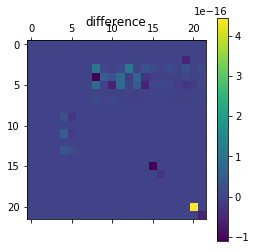

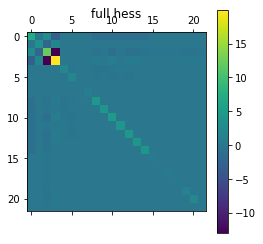

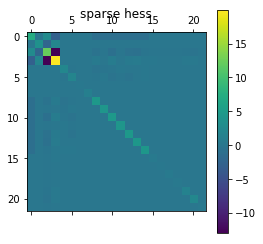

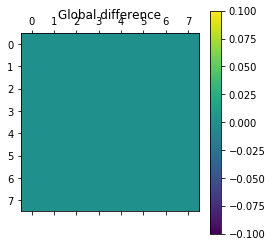

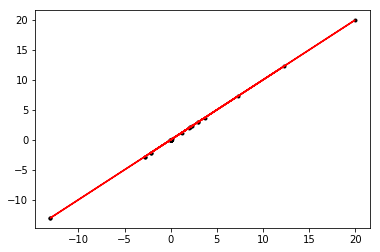

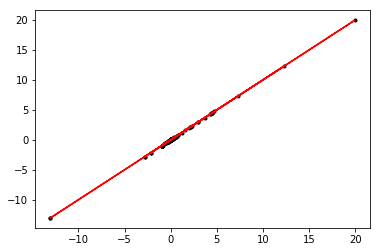

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
global_ind = group_model.global_indices.get_vector()

sp_hess = np.array(sparse_vector_hess.todense())
plt.matshow(full_vector_hess - sp_hess); plt.colorbar()
plt.title("difference")

plt.matshow(full_vector_hess); plt.colorbar()
plt.title("full hess")

plt.matshow(sp_hess); plt.colorbar()
plt.title("sparse hess")

plt.matshow((full_vector_hess - sp_hess)[np.ix_(global_ind, global_ind)]); plt.colorbar()
plt.title("Global difference")

plt.figure()
plt.plot(full_vector_hess[np.ix_(global_ind, global_ind)].flatten(),
         sp_hess[np.ix_(global_ind, global_ind)].flatten(), 'k.')
plt.plot(full_vector_hess.flatten(), full_vector_hess.flatten(), 'r')

plt.figure()
plt.plot(full_vector_hess.flatten(), sp_hess.flatten(), 'k.')
plt.plot(full_vector_hess.flatten(), full_vector_hess.flatten(), 'r')